In [47]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

mp.dps = 64
eps = 1e-64

class GramSchmidt:
    def __init__(self, x, m):
        self.x = x 
        self.m = m 
        self.A = mp.zeros(m, len(x))
        #Linear map for polynomial scalar product
        for i in range(m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                self.A[i, j] = x[j]**i

        #Write basis vector as columns of matrix V
        self.V = mp.eye(m)

        self.U = self.modifiedGramSchmidt(self.V) 

    def evaluateBasis(self, x, basis_element): 
        #Linear map for polynomial scalar product
        A = mp.zeros(self.m, len(x))
        for i in range(self.m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                A[i, j] = x[j]**i
        ei = self.U[:, basis_element].T * A 
        
        return ei
    
    def sp(self, u, v):
        return mp.fsum((u.T * self.A) * (v.T * self.A).T)

    def proj(self, u, v):
        a1 = self.sp(v, u) 
        a2 = self.sp(u, u)
        return a1/a2 * u 

    def norm(self, u):
        return mp.sqrt(self.sp(u, u))

    def modifiedGramSchmidt(self, V): 
        n, k = V.rows, V.cols
        U    = V.copy()
        U[:, 0] = V[:, 0] / self.norm(V[:, 0]) 

        for i in range(1, k): 
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])


            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def projectFunction(self, f): 
        coeffs = mp.matrix(1, self.m) 

        for i in range(self.m): 
            basis = (self.U[:, i].T * self.A)
            coeffs[0, i] = mp.fsum(f * basis.T)


        return coeffs
    
    def reconstructFunction(self, coeffs, x = None): 
        if x == None:
            A = self.A
        else: 
            A = mp.zeros(self.m, len(x))
            for i in range(self.m): 
                for j in range(len(x)): 
                    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                    self.A[i] = x[j]**i
            
        frec = mp.matrix(1, A.cols)
        for i in range(self.m): 
            frec += coeffs[0, i] * (self.U[:, i].T * A)
        return frec 
    
    def debugInformation(self):
        m = self.m 
        u_ij = mp.zeros(m) 

        plt.title(f"Unorthogonalised polynomials m = {m}")
        for i in range(m):
            plt.plot(x, self.V[:, i].T * self.A, label=f"x^{i}")
        plt.legend()
        plt.show()



        plt.title(f"Orthonormalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.U[:, i].T * self.A, label=f"{i}")
        plt.legend()
        plt.show()

        print("The orthonormalised polynomials and their scalar products")
        for i in range(m):
            for j in range(m):
                u_ij[i, j] = self.sp(self.U[:, i], self.U[:, j])
            print(f"i = {i} u_ij = {u_ij[i, :]}")


for m in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]: 

    x = mp.linspace(-1, 1, m)

    gs = GramSchmidt(x, m)

    Pos2Poly = mp.matrix(m, m)
    Poly2Int = mp.matrix(m, 2 * (m - 2))
    for i in range(m): 
        Pos2Poly[i, :] = gs.evaluateBasis(x, i)

    dx = 2.0/(m-1)
    x = mp.linspace(-1 + 0.75 * dx , 1 - 0.75 * dx, 2 * (m - 2))
    for i in range(m): 
        Poly2Int[i, :] = gs.evaluateBasis(x, i)

    Pos2Int = Poly2Int.T * Pos2Poly

    P = np.array(Pos2Int, dtype=float).reshape(2 * (m - 2), m) 
    P.tofile(f"/home/calab912/Documents/IPR/polynomial/N={m}.bin")


[0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375] [0.046875 0.078125 0.109375 0.140625 0.171875 0.203125 0.234375 0.265625
 0.296875 0.328125 0.359375 0.390625 0.421875 0.453125 0.484375 0.515625
 0.546875 0.578125 0.609375 0.640625 0.671875 0.703125 0.734375 0.765625
 0.796875 0.828125 0.859375 0.890625]


2.8994663812755206e-17

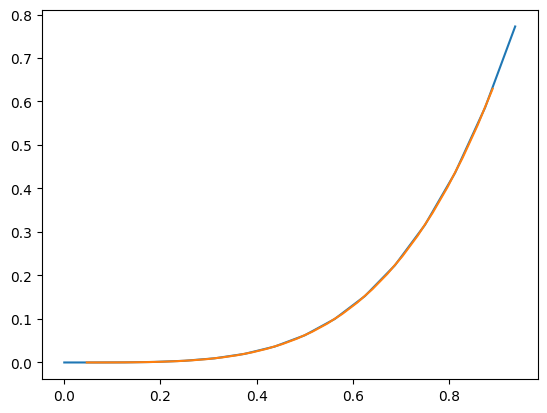

In [52]:
m = 16
x  = np.linspace(0, 1, m+1)[:-1]
dx = x[1] - x[0]

xh = np.linspace(0.75*dx, x[-1]-0.75*dx, 2*(m-2)) 
print(x, xh) 
def func(x):
    return x**4#1/(1 + 25 * x**2) 
f  = func(x) 
fh = func(xh)  
P = np.fromfile(f"PolyInt_N={m}.bin").reshape(2 * (m - 2), m) 
frec = P@f
plt.plot(x, f)
plt.plot(xh, frec)

np.mean(np.abs(frec - fh))